## A neural mass model with D1 dopaminergic modulation

In this notebook we show the use of a neural mass model equipped with D1 dopaminergic modulation of AMPA currents. This model is an extended version of the work of Gast et al (https://doi.org/10.1073/pnas.2311885121) that includes a dose-dependent neuromodulatory effect of dopamine, similarly to that of Depannemaecker et al (https://doi.org/10.1101/2024.06.23.600260). 

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

import gast_model as gm
from utils import *

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## Single node implementation

Here we implement a single node simulation to display the different behaviours of the model by modulating the internal current I.

In [5]:
setup = {
    'dt': 0.1,
    'T': 30000.0,  # ms
    'noise': 0.,
    'key': jax.random.PRNGKey(42),
    'variables': ['r', 'v', 'u', 's'],
}

def format_ticks(x, pos):
        return '{:.1f}'.format(x * setup['dt'] * 1e-3)

C = jnp.zeros((1, 1)) # only one node
params = gm.default_theta # getting the default parameters

In [6]:
def setup_simulation(setup, C):

    _, loop = make_sde(setup['dt'], gm.net, setup['noise'], adhoc=gm.stay_positive)  # creating the equations
    dW = jax.random.normal(setup['key'], (int(setup['T'] / setup['dt']), len(setup['variables']), C.shape[0]))  # assigning the noise
    init = jnp.array([0., -50, 0., 0.04])  # Initialization of the variables
    init = jnp.outer(init, jnp.ones(C.shape[0]))

    return loop, dW, init

In [7]:
# Changing the default parameters
params = params._replace(C=100, Delta=.5, kappa=100, I=50)
print(params)
# Generating the integration function
loop, dW, init = setup_simulation(setup, C)
# Integrating the time serie
ys = loop(init, dW, (C, params))
print(f'Simulation output has shape: {ys.shape}')

Theta(C=100, k=0.7, Delta=0.5, v_r=-60.0, v_theta=-40.0, g=1.0, E=0.0, I=50, tau_u=33.33, b=-2.0, kappa=100, tau_s=6.0, J=15.0, Js=0.0, we=0.0)
Simulation output has shape: (300000, 4, 1)


Running for I = 45
Running for I = 50
Running for I = 60
Running for I = 65


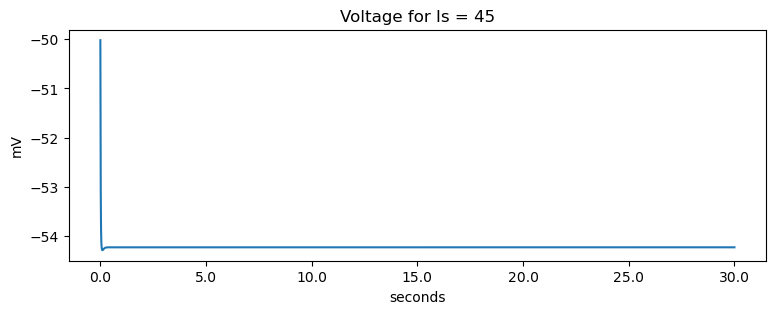

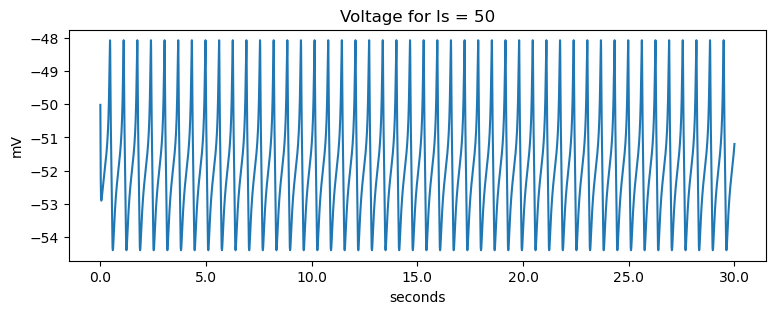

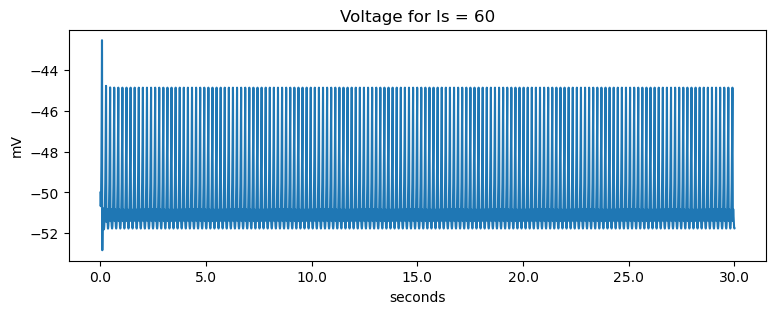

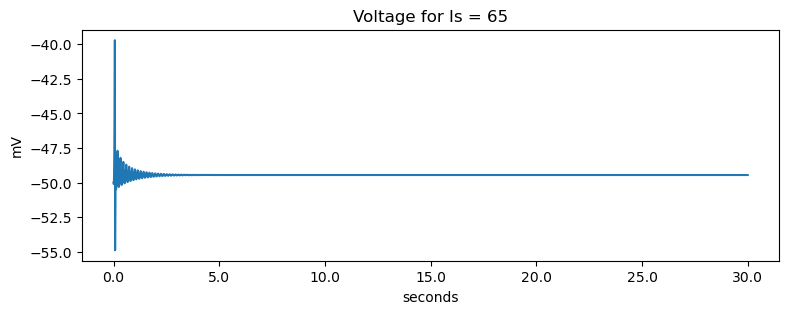

In [8]:
Is = [45,50,60,65]

for Ix in Is:
    params = params._replace(I=Ix)
    print(f'Running for I = {params.I}')
    ys = loop(init, dW, (np.zeros((1, 1)), params))

    plt.figure(figsize=(9,3))
    plt.plot(ys[:,1])
    plt.title(f'Voltage for Is = {Ix}')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.xlabel('seconds')
    plt.ylabel('mV')

## Whole brain simulations

Here we display simulations for the full system (with excitation, inhibition and dopamine). The simulations are implemented using either Desikan-Killiany atlas (68 cortical and 16 subcortical regions) or Schaefer 7 Networks atlas (100 cortical and 16 subcortical regions). To these, 4 extra regions were added, namely the Left and Right Substantia nigra and Ventral Tegmental Area. 

To adjust the connectome accordingly, two strategies were adopted:
1. For the DK atlas, weights of the connections to and from the SN and the VTA were included according to the values reported by Handfield-Jones, Nicholas, "Connectomic Analysis of Substantia Nigra Pars Compacta and Ventral Tegmental Area Projections to the Striatum and Cortex" (2019). Electronic Thesis and Dissertation Repository. 6463. https://ir.lib.uwo.ca/etd/6463 
2. For the Schaefer atlas, since region labelling does not follow canonical anatomical names, we used the D1 receptor density of each area as a surrogate for the connectivity weight between the specific area and the SN or the VTA.

First we check the connectivity masks and the weights

In [13]:
import numpy as np
import pandas as pd

atlas = 'schaefer' # schaefer or dk

data_path = f'structural_data/{atlas}/'
Ce_mask = pd.read_csv(data_path+f'{atlas}_exc_mask.csv', index_col=0)
Ci_mask = pd.read_csv(data_path+f'{atlas}_inh_mask.csv', index_col=0)
Cd_mask = pd.read_csv(data_path+f'{atlas}_dopa_mask.csv', index_col=0)
weights = pd.read_csv(data_path+f'{atlas}_weights_with_dopa.csv', index_col=0)
weights = weights/np.max(weights)
regions_names = list(weights.index)

Ce = jnp.array(weights * Ce_mask)
Cd = jnp.array(weights * Cd_mask)
Ci = jnp.array(weights * Ci_mask)



/var/folders/65/0rggzw_s3c39y4m504krlw380000gn/T/ipykernel_90106/667808010.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[1, 0.05, 1, 1])
/var/folders/65/0rggzw_s3c39y4m504krlw380000gn/T/ipykernel_90106/667808010.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[1, 0.05, 1, 1])


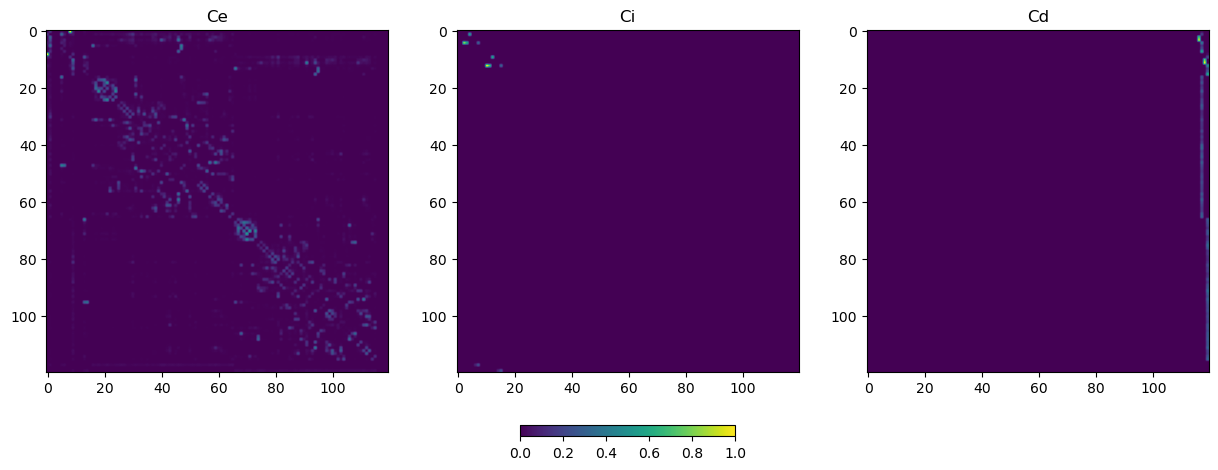

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

im1 = axs[0].imshow(Ce)
axs[0].set_title('Ce')
im2 = axs[1].imshow(Ci)
axs[1].set_title('Ci')
im3 = axs[2].imshow(Cd)
axs[2].set_title('Cd')

cbar = fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout(rect=[1, 0.05, 1, 1]) 

plt.show()

Now we set the dopamine receptors according to weather the region was set to receive dopamine from the connectome and the corresponding normalized number of D1 receptors obtained by processing data in Kaller et al (doi: 10.1007/s00259-017-3645-0)

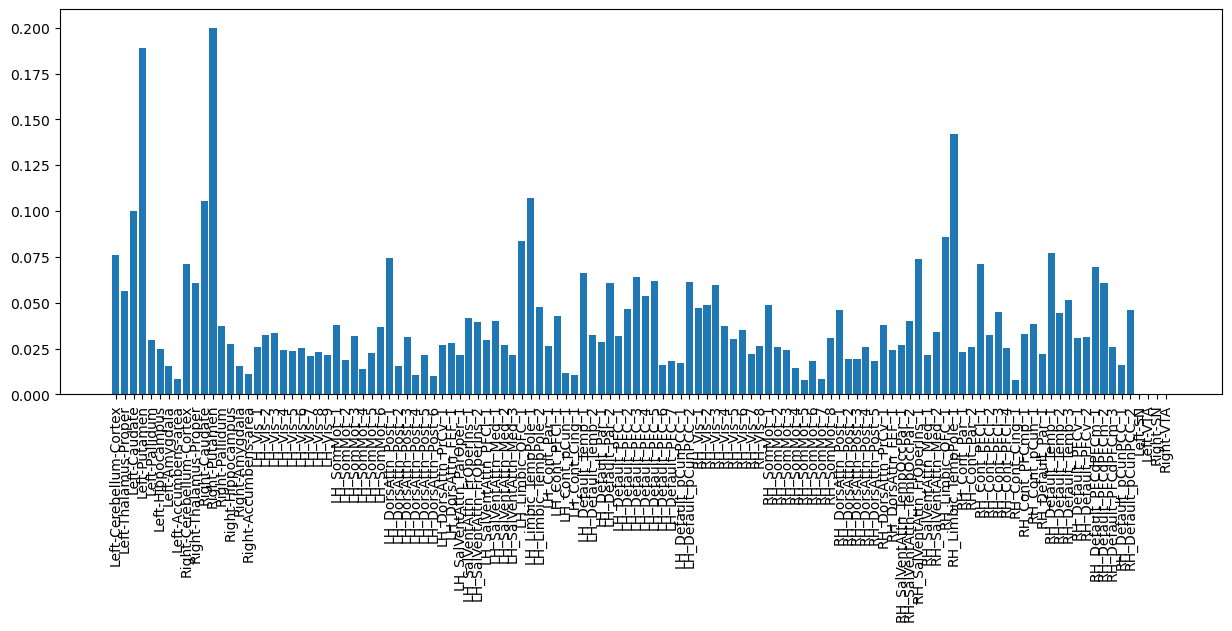

In [256]:
receptor_list = pd.read_csv(data_path+f'{atlas}_D1receptor_data.csv') # full receptor list

# Assigning 0 dopaminergic receptors to all the nodes not receiving dopamine. RRd stands for Regional Rd
RRd = np.zeros((Cd.shape[0]))
RRd[np.where(Cd!=0)[0]] = 1

for i, row in receptor_list.iterrows():
    RRd[i] = RRd[i] * row['numbers_of_receptors']/(5 * np.max(receptor_list['numbers_of_receptors']))

# Check
plt.figure(figsize=(15,5))
plt.bar(regions_names, RRd)
plt.xticks(rotation=90)
plt.show()

Now we set self-inhibition only in those regions that are inhibitory (which will also have 0 self-excitation)

['Left-Caudate', 'Left-Putamen', 'Left-Pallidum', 'Left-Amygdala', 'Left-Accumbens-area', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala', 'Right-Accumbens-area']


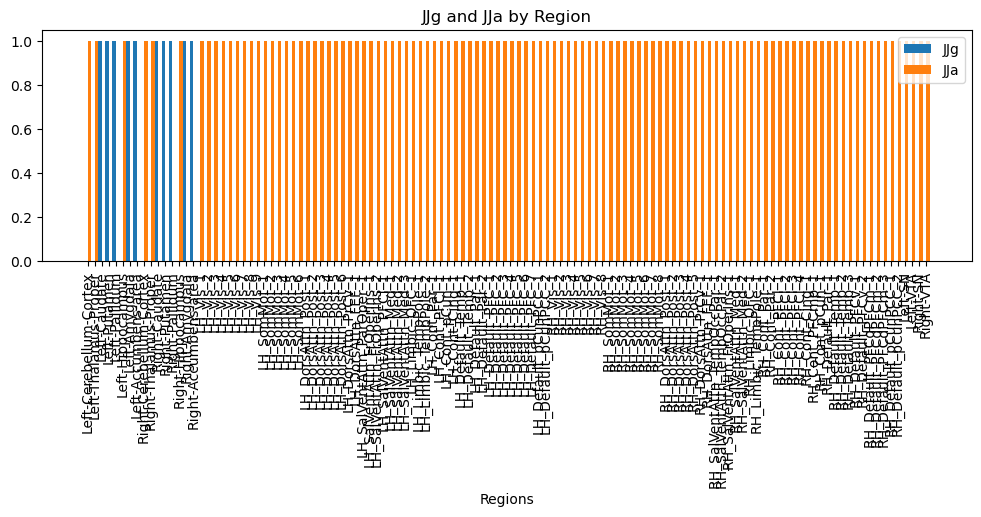

In [17]:
# Inhibitory regions
print([regions_names[i] for i in np.unique(np.where(Ci!=0)[1])])

# Setting Jg to one for all region that are inhibitory
JJg = np.zeros((Ci.shape[0]))
JJg[np.unique(np.where(Ci!=0)[1])] = 1
JJg = jnp.array(JJg)

# Setting Ja to 0 for all regions that are inhibitory
JJa = np.ones((Ce.shape[0]))
JJa[np.unique(np.where(Ci!=0)[1])] = 0
JJa = jnp.array(JJa)

bar_width = 0.5
index = np.arange(len(regions_names))
plt.figure(figsize=(12, 3))
plt.bar(index, JJg, bar_width, label='JJg')
plt.bar(index + bar_width, JJa, bar_width, label='JJa')
plt.xlabel('Regions')
plt.title('JJg and JJa by Region')
plt.xticks(index + bar_width / 2, regions_names, rotation = 90)
plt.legend()
plt.show()

Now it is time to do some simulations!

In [18]:
dopa_setup = {
    'dt': 0.5,
    'T': 30000.0,  # ms
    'noise': jnp.array([0., 0.1, 0.01, 0., 0., 0., 0.]).reshape(-1,1),
    'sigma': 1.,
    'key': jax.random.PRNGKey(42),
    'variables': ['r', 'v', 'u', 'sa', 'sg', 'Dp', 'Md'],
}

def dopa_setup_simulation(dopa_setup, regions_names):
    _, loop = make_sde(dopa_setup['dt'], gm.dopa_net, dopa_setup['noise']*dopa_setup['sigma'], adhoc=gm.dopa_stay_positive)  # creating the equations
    dW = jax.random.normal(dopa_setup['key'], (int(dopa_setup['T'] / dopa_setup['dt']), len(dopa_setup['variables']), len(regions_names)))  # assigning the noise
    init = jnp.array([0., -50, 0., 0.04, 0., 0., 0.,])  # Initialization of the variables
    init = jnp.outer(init, jnp.ones(len(regions_names)))

    return loop, dW, init

def format_ticks(x, pos):
    return '{:.1f}'.format(x * dopa_setup['dt'] * 1e-3)

To get started, we = - 0,06 \* J - 0,05 \* I + 3,37 gives nice WE to use. J can be in range 11-17 and I 45-47.
1. For DK atlas, we=0.21, wi=0.1, wd=0.15 are at a good working point
2. For Schaefer, we=0.32, wi=0.1, wd=0.4

For the noise, sigma at aroung 1 also works to start.

In [289]:
params = gm.dopa_default_theta
params = params._replace(I=46.5, Ja=JJa*13, Jg=JJg*15, Jsa=13, Jsg=15.0, 
                         Rd=RRd, Jdopa=100000, Sd=-10, Z=0.5, tau_Md=1000, we=0.32, wi=0.1, wd=0.4)

In [290]:
loop, dW, init = dopa_setup_simulation(dopa_setup, regions_names)
ys = loop(init, dW, (Ce, Ci, Cd, params)) # shape of ys output is [time points, variables, nodes]

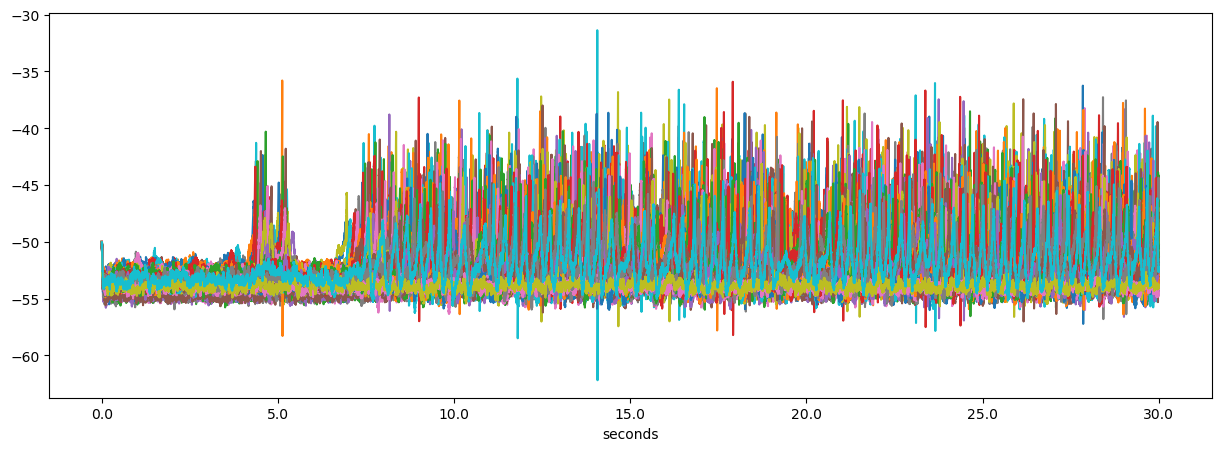

In [291]:
#dopa_regions = np.unique(np.where(Cd!=0)[0])
plt.figure(figsize=(15,5))
plt.plot(ys[:,1])
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.xlabel('seconds')
#plt.legend([regions_names[i] for i in dopa_regions])
plt.show()

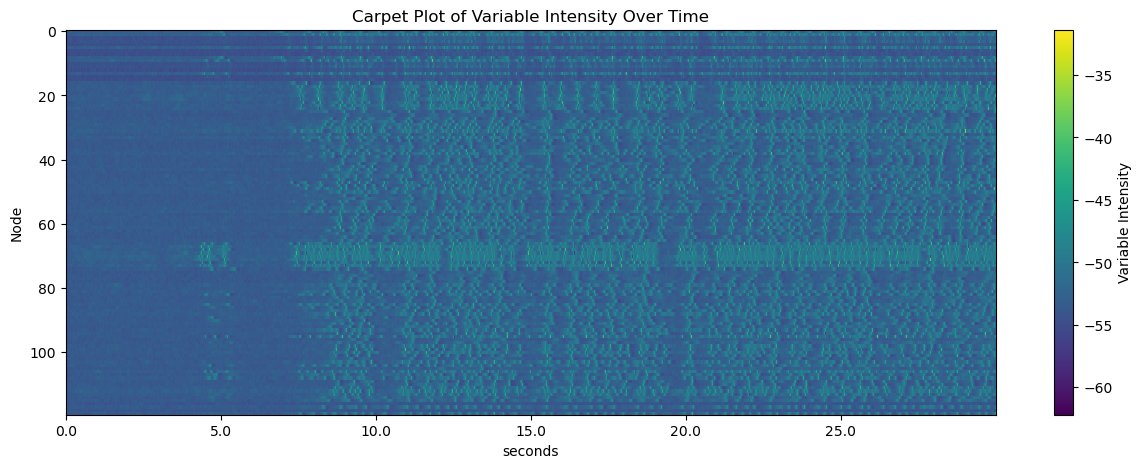

In [292]:
plotting_data = ys[:, 1, :] 
plt.figure(figsize=(15, 5))
plt.imshow(plotting_data.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.xlabel('Time')
plt.ylabel('Node')
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.xlabel('seconds')
plt.title('Carpet Plot of Variable Intensity Over Time')
plt.colorbar(label='Variable Intensity')

# Show the plot
plt.show()

## Now, BOLD!

In [68]:
def format_ticks1(x, pos):
        return '{:.0f}'.format(x * 0.5 * 2 * 1e-3) # because of the temporal_average

In [293]:
sigma = 1.
params = gm.dopa_default_theta
params = params._replace(I=46.5, Ja=JJa*13, Jg=JJg*15, Jsa=13, Jsg=15.0, 
                         Rd=RRd, Jdopa=100000, Sd=-10, Z=0.5, tau_Md=1000, we=0.32, wi=0.1, wd=0.4)

p = Ce, Ci, Cd, params, sigma  #parameters for the network

rng_key = jax.random.PRNGKey(0)

ta, bold = run_for_parameters(p, rng_key)

Simulating BOLD took  15.668027877807617  seconds


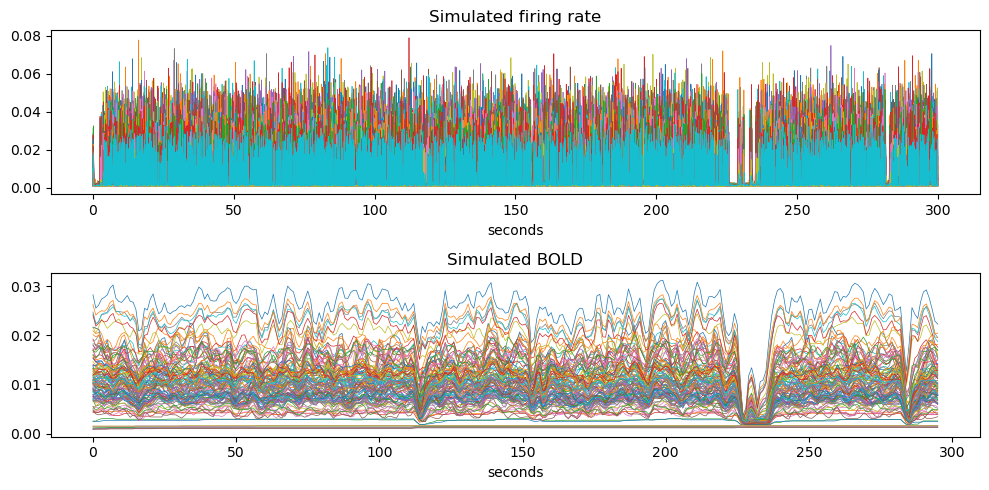

In [294]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
for i in range(len(regions_names)) : plt.plot(ta[:, 0, i], lw=0.5)
plt.title('Simulated firing rate')
plt.xlabel('ms')
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks1))
plt.xlabel('seconds')

plt.subplot(2, 1, 2)
for i in range(len(regions_names)) : plt.plot(bold[:, i], lw=0.5)
plt.title('Simulated BOLD')
plt.xlabel('seconds')

plt.tight_layout()
plt.show()

Let's compute the Fucntional Connectivity matrix (FC), the Functional Connectivity Dynamics matrix (FCD), the Structural-Fuctional Connectivity Correlation (SCFC) and the Variance of the FCD (VAR_FCD).

To do so, we remove subcortical regions from the computation so that we only have cortical areas. 
1. In the dictionary idx_to_remove, DK regions correspond to ['L.CER', 'L.TH', 'L.CA', 'L.PU', 'L.PA', 'L.AM', 'L.AC', 'R.TH', 'R.CA', 'R.PU', 'R.PA', 'R.AM', 'R.AC', 'L.SN', 'L.VTA', 'R.SN', 'R.VTA', 'R.CER']. 
2. For Schaefer, they correspond to ['Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
 'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Left-Nigra', 'Left-VTA', 'Right-Nigra', 'Right-VTA']
 3. For AAL2, ['Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Amygdala_L', 'Amygdala_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10', 'Nigra_L', 'VTA_L', 'Nigra_R', 'VTA_R']

In [ ]:
idx_to_remove = { 'dk' : [34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 83, 84, 85, 86, 87], 
'schaefer' : [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 116, 117, 118, 119],
 'aal2' : [74, 75, 76, 77, 78, 79, 80, 81, 44, 45, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123]
}

print(len(idx_to_remove['dk']))
#print([regions_names[i] for i in idx_to_remove['dk']])
print(len(idx_to_remove['schaefer']))
#print([regions_names[i] for i in idx_to_remove['schaefer']])

weights_reduced = np.delete(weights, idx_to_remove[atlas], axis=0) 
weights_reduced = np.delete(weights_reduced, idx_to_remove[atlas], axis=1)


print(f'Cortical-only Connectome has shape: {weights_reduced.shape}')

18
18
Cortical-only Connectome has shape: (102, 102)


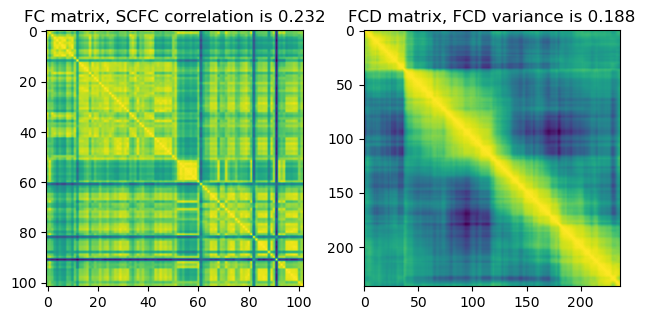

In [74]:
bold_reduced = np.delete(bold, idx_to_remove[atlas], axis=1)
FC = np.corrcoef(bold_reduced.T)
FC = np.nan_to_num(FC, 0)  # Replace NaNs with 0s
#FC = np.nan_to_num(FC, 0)
SCFC = np.corrcoef(np.triu(FC, k=1).ravel(), np.triu(weights_reduced, k=1).ravel())[0,1]
FCD = compute_fcd(bold_reduced, 60, 59)
VAR_FCD = np.var(np.triu(FCD, k=1))


plt.subplot(121)
plt.imshow(FC)
plt.title(f'FC matrix, SCFC correlation is {np.round(SCFC,3)}')
plt.subplot(122)
plt.imshow(FCD)
plt.title(f'FCD matrix, FCD variance is {np.round(VAR_FCD,3)}')
plt.tight_layout()


## A quick sweep over wd

In [297]:
sweep_results = []
np.seterr(invalid='ignore')
for we_value in np.linspace(0.1, 0.8, 15):
    params = gm.dopa_default_theta
    params = params._replace(I=46.5, Ja=JJa*13, Jg=JJg*0, Jsa=13, Jsg=15.0, 
                            Rd=RRd, Jdopa=100000, Sd=-10, Z=0.5, tau_Md=1000, we=we_value, wi=0.1, wd=0.3)

    p = Ce, Ci, Cd, params, sigma  #parameters for the network

    rng_key = jax.random.PRNGKey(0)

    ta, bold = run_for_parameters(p, rng_key)

    bold_reduced = np.delete(bold, idx_to_remove[atlas], axis=1)
    FC = np.corrcoef(bold_reduced.T)
    FC = np.nan_to_num(FC, 0)
    SCFC = np.corrcoef(np.triu(FC, k=1).ravel(), np.triu(weights_reduced, k=1).ravel())[0,1]
    SCFC = np.nan_to_num(SCFC, 0)
    FCD = compute_fcd(bold_reduced, 20, 19)
    VAR_FCD = np.var(np.triu(FCD, k=1))
    VAR_FCD = np.nan_to_num(VAR_FCD, 0)

    sweep_results.append([we_value, SCFC, VAR_FCD])


Simulating BOLD took  15.61575198173523  seconds
Simulating BOLD took  15.919437170028687  seconds
Simulating BOLD took  15.651989936828613  seconds
Simulating BOLD took  15.797714948654175  seconds
Simulating BOLD took  15.813455820083618  seconds
Simulating BOLD took  15.501913070678711  seconds
Simulating BOLD took  15.826446056365967  seconds
Simulating BOLD took  15.63801383972168  seconds
Simulating BOLD took  15.981202840805054  seconds
Simulating BOLD took  16.00003480911255  seconds
Simulating BOLD took  15.516120195388794  seconds
Simulating BOLD took  15.820601224899292  seconds
Simulating BOLD took  15.835617780685425  seconds
Simulating BOLD took  15.766963958740234  seconds
Simulating BOLD took  15.479947090148926  seconds


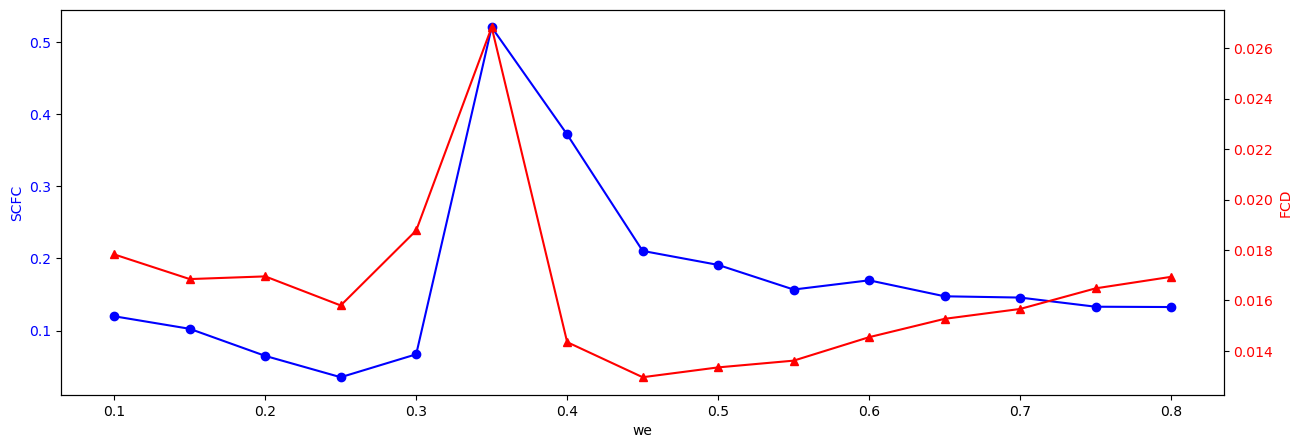

In [298]:
results_df = pd.DataFrame(sweep_results, columns=['we', 'SCFC', 'FCD'])

fig, ax1 = plt.subplots(figsize=(15, 5))

ax1.plot(results_df['we'], results_df['SCFC'], 'o-', color='blue', label='SCFC')
ax1.set_xlabel('we')
ax1.set_ylabel('SCFC', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(results_df['we'], results_df['FCD'], '^-', color='red', label='FCD')
ax2.set_ylabel('FCD', color='red')
ax2.tick_params(axis='y', labelcolor='red')

## Seggested adjustment for Schaefer

For better activity in the basal ganglia, I suggest to set I of the Pallidum to 1.2-1.3
and the Ja of the Substantia nigra to 1.5
and not to put self-inhibition in inhibiting nuclei. 

In [ ]:
II = np.ones((Ce.shape[0]))
II[regions_names.index('Left-Pallidum')] = 1.3
II[regions_names.index('Right-Pallidum')] = 1.3

JJa = np.ones((Ce.shape[0]))
JJa[regions_names.index('Left-SN')] = 1.5
JJa[regions_names.index('Right-SN')] = 1.5
JJa[np.unique(np.where(Ci!=0)[1])] = 0
JJa[regions_names.index('Left-Amygdala')] = 1
JJa[regions_names.index('Right-Amygdala')] = 1
JJa = jnp.array(JJa)

JJg = 0